# Can you predict which NBA players will make the "All-Star" team?

## Part 1: Clean the data

#### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import numpy as np

#### Load 'player_data' and explore the basics that you feel are relevant 

In [2]:
df=pd.read_csv("player_data.csv", delimiter=',')
df.drop(columns=df.columns[0], axis=1,  inplace=True)

df.head()

df.columns

Index(['Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'PER', 'TS%', 'ORB%', 'DRB%',
       'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'WS', 'BPM', 'VORP', 'FG%',
       '3P%', '2P%', 'eFG%', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS'],
      dtype='object')

#### Drop the One column that you think will be useless for your use case

In [3]:

null_percentage = (df.isnull().sum() / len(df)) * 100

# Just checking if there was any column with a super high percentage of nulls that would be good to drop, 
# but I see there is a task later on to fill those values so I don't think this is a good approach.
print(null_percentage[null_percentage > 20])

TOV%    20.691750
3P%     37.564295
TOV     20.436596
dtype: float64


In [4]:
correlation_matrix=df.corr()

C:\Users\luana\AppData\Local\Temp\ipykernel_25368\2312581054.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix=df.corr()


In [5]:
# Create an array of dictionaries to store correlations and column names
correlation_list = []

# Iterate through the correlation matrix and populate the array of dictionaries
for row in correlation_matrix.index:
    for column in correlation_matrix.columns:
        if row != column:
            correlation_value = correlation_matrix.loc[row, column]
            correlation_dict = {
                'Column_1': row,
                'Column_2': column,
                'Correlation_Value': correlation_value
            }
            correlation_list.append(correlation_dict)

sorted_correlation_list = sorted(correlation_list, key=lambda x: x['Correlation_Value'], reverse=True)

# Print the sorted array of dictionaries
for i in range(15):
    print(sorted_correlation_list[i])


{'Column_1': 'FG%', 'Column_2': 'eFG%', 'Correlation_Value': 0.9443898029542377}
{'Column_1': 'eFG%', 'Column_2': 'FG%', 'Correlation_Value': 0.9443898029542377}
{'Column_1': 'TS%', 'Column_2': 'eFG%', 'Correlation_Value': 0.9401293905262684}
{'Column_1': 'eFG%', 'Column_2': 'TS%', 'Correlation_Value': 0.9401293905262684}
{'Column_1': 'FG%', 'Column_2': '2P%', 'Correlation_Value': 0.9368610752096087}
{'Column_1': '2P%', 'Column_2': 'FG%', 'Correlation_Value': 0.9368610752096087}
{'Column_1': '2P%', 'Column_2': 'eFG%', 'Correlation_Value': 0.913061260485256}
{'Column_1': 'eFG%', 'Column_2': '2P%', 'Correlation_Value': 0.913061260485256}
{'Column_1': 'TOV', 'Column_2': 'PTS', 'Correlation_Value': 0.9098953256508043}
{'Column_1': 'PTS', 'Column_2': 'TOV', 'Correlation_Value': 0.9098953256508043}
{'Column_1': 'WS', 'Column_2': 'VORP', 'Correlation_Value': 0.905952850287726}
{'Column_1': 'VORP', 'Column_2': 'WS', 'Correlation_Value': 0.905952850287726}
{'Column_1': 'DRB%', 'Column_2': 'TRB%

In [6]:
#key_counts = Counter(item[target_key] for item in sorted_correlation_list)
filter_list=[(x["Column_1"], x["Column_2"]) for x in sorted_correlation_list if x["Correlation_Value"] >= 0.9]

print(Counter(itertools.chain(*filter_list)))

Counter({'eFG%': 6, 'FG%': 4, '2P%': 4, 'TS%': 2, 'TOV': 2, 'PTS': 2, 'WS': 2, 'VORP': 2, 'DRB%': 2, 'TRB%': 2})


In [7]:
df.drop("eFG%", inplace=True, axis=1)

I Drop the eFG column because the correlation matrix gives me the information that eFG is above 90% correlated to other three columns so I would be too redundant to use it.

#### Replace null values with 0's in the '3P%' column

In [8]:
df["3P%"].fillna(value=0, inplace=True)

#### Remove rows for players who Started their careers (made their Debut) before the 1980 season

In [9]:
df_players= df[df["Year"] < 1980]["Player"].unique()

In [10]:
df_filtered=df[~df["Player"].isin(df_players)].copy()
df=df_filtered.copy()


#### Load in the 'all_star_appearances.pickle' file and use this data to create a column called 'all_star' that indicates whether or not a player made the All-Star team for a given year
- This file is a dictionary in which the keys are players who've made an All-Star team in their careers
- The values are all the years that the corresponding player made an All-Star team

In [11]:
all_star = pd.read_pickle("all_star_appearances.pickle")
all_star = dict(all_star)

In [12]:
# The approach here is to verify in the all_star dictionary if that Year was contained in the list of years of that Player.

df["is_in"] = df[["Player", "Year"]].apply(lambda x: x["Year"] in all_star.get(x["Player"],[]),axis=1 )

#### Make sure this column is binary where 1 = Made All-Star team, and 0 = Did not make All-Star team

In [13]:
# To assure the values follows the specification, the booleans are cast to int
df["is_in"] = df["is_in"].apply(lambda x : int(x))

## Part 2: Exploratory data analysis

#### Generate descriptive stats for the features

#### Graph the distibution of the 'Age' feature. What conclusion can you reach from this?

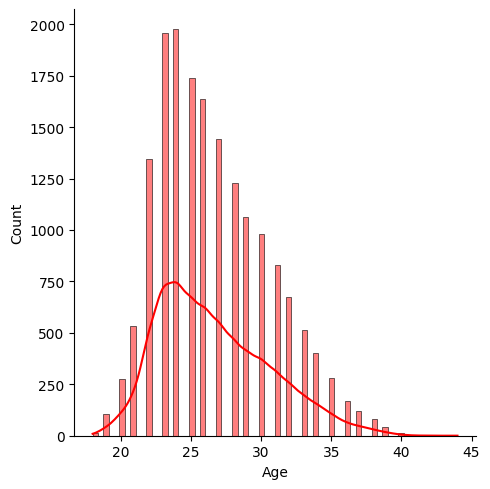

In [14]:
sns.displot(df["Age"],kde=True, color="Red")

From the distribution of the players age we can notice a few things:

The majority of NBA players are 24 years old.

The distribution is right skewed which means that the mean is greater than the mode. In this case, when we create a description of Age column we can see that the mean is amost 26.6 years old, but the mode is 24.

#### Create a correlation map of the features

C:\Users\luana\AppData\Local\Temp\ipykernel_25368\752845423.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


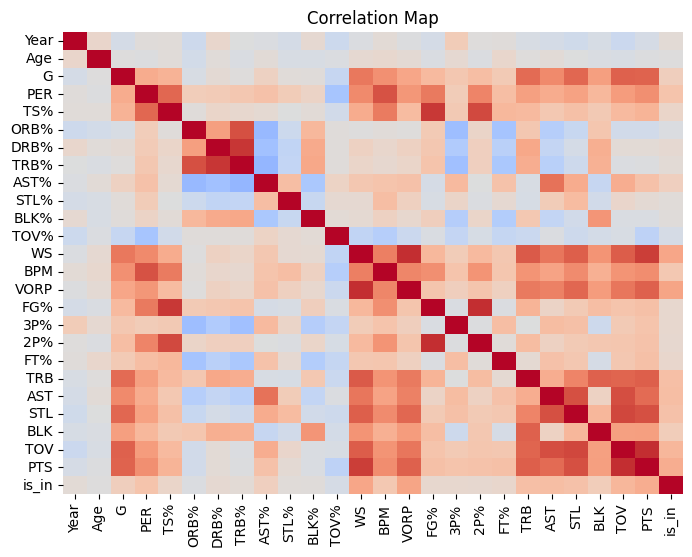

In [15]:
correlation_matrix = df.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0,cbar=False)
plt.title('Correlation Map')
plt.show()

#### Remove Features that you consider to be too correlated or "duplicated"

In [16]:
#Dropping the FG column because its correlation with other two columns is above 90% so It would be too redundant to use it.
df.drop("FG%", inplace=True, axis=1)

## Part 3: Modeling

#### Build a simple classifier that predicts whether or not a player makes an All-Star team based on their stats for that season.

In [17]:
df = df.dropna()
y = df[['is_in','Player']]
X = df.drop(['is_in', 'Player'], axis=1)


In [18]:
label_encoder = LabelEncoder()
X['Pos'] = label_encoder.fit_transform(X['Pos'])
X['Tm'] = label_encoder.fit_transform(X['Tm'])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [20]:
model = XGBClassifier()

In [21]:
model.fit(X_train, y_train['is_in'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [22]:
y_pred = model.predict(X_test)

In [23]:
y_test["pred"] = y_pred


In [24]:
cm = confusion_matrix(y_test['is_in'], y_test['pred'])

In [25]:
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a DataFrame for the normalized confusion matrix
normalized_cm_df = pd.DataFrame(normalized_cm, index=["True Class 0", "True Class 1"], columns=["Predicted Class 0", "Predicted Class 1"])

# Print the normalized confusion matrix table
print("Normalized Confusion Matrix:")
print(normalized_cm_df)

Normalized Confusion Matrix:
              Predicted Class 0  Predicted Class 1
True Class 0           0.991935           0.008065
True Class 1           0.484663           0.515337


The confusion matrix above gives us an ideia of how well our model predicted the players that were and were not selected to all star game.

We can see that for all players that were not selected, our model did very well, having predicted 99% of them correctly.

Unfortunately for all the players that were selected, our model didn't go that well, having predicted correctly only 51% of them.

That being said, this is likely because our dataset is unbalanced in a way that there are more players that end up not making all star than those who do.

## Part 4: Data Engineering

#### Imagine that we are in 2017 and we collect this data from each of the 31 teams that play on the NBA. Each one of the teams exposes a REST API endpoint for us to extract the data and process it, this means that we have to do 31 different GET requests on each update. We are building a Web Application for ESPN and they need this data to be updated on daily basis, so when sports analysts start working in the morning they have fresh stats to go over and can give informed predictions in TV about which players will be making the All-Star team. We have an approximate of 12 users that will be using the product on daily basis.

#### At the end of each season, we will update the Pickle file (which is stored in a Bucket in Cloud Object Storage) to include the players that were included in the All-Star team and keep the dataset and model updated. All the development will be done in Python, and the architecture of the ETL process will be defined by you, along with the Cloud Service Provider (you can choose between AWS, GCP, Azure). Don't worry about the Backend and Frontend of the App, that will be defined and implemented by the Development team, but they are waiting on your decision on which database to use.

#### Would you use a dedicated server or a serverless architecture? Why?

I would use a serverless architecture for the following reasons:

* It is easier and practical to manage, since we are not responsible for provision of machines and for the infrastructure.
In this way we only need to take care of pythons scripts that would do the jobs.

* We don't actually need a dedicated server since the routines would be done a low number of times per day. It would be
cheaper, instead of paying for a full dedicated machine we would only pay for the time the processes are running or requests are made.

#### What Computing resources would you use? Why?

* Google Functions : To execute scripts that would move the data from one place to another, for example, to extract the data from the APIs and load them into BigQuery.

* Cloud Run API : To deploy the container that will load the ML model, generate the predictions and make it available on the API.

* Cloud Build API : This service will basically allow us to configure the environment and the CI/CD.

#### What type of storage would you choose? How would you guarantee data quality and consistency?

* Google Stortage - For the pickle file, since It is mentioned that it should be in a Cloud Object Storage.

* Google Big Query - To store the teams data and the predictions made by the ML model.

#### What Security considerations would you implement for these architecture?

The only security consideration I would make would be to use Google OAuth to authorize the client in the browser when they access the API. The client would use the HTTP Authorization to make requests to Cloud Run.

#### What type of monitoring, costs analysis and application performance should this architecture have?

Google offers a service in which we can export the billing costs of a project to BigQuery,
thus we can use this to keep track of the costs involved in all the services linked to this
especific project and connect Big Query to Power BI, for example, to build reports on these costs.

#### Please do a simple sketch of the Architecture for this application and explain it in a brief paragraph (you can keep it simple, don't worry too much about the design)

There would be daily routines triggered by Google Scheduler to extract the data from the teams APIs (31 as mentioned in the description). They would be extracted via Google Functions (data can be treated during this process) and then stored in BigQuery. Once the data is available in BigQuery it is then consumed by the ML model that will run in a Docker container using Cloud Run API, and this service will also provide an API Endpoint from which the Back End of some application (app or website) can access the predictions. Once the predictions are available, we can also store them on BigQuery so we have all the predictions available for analysts to have a complete historic of the player's probability of entering all star. Once a year, when the all star players were revealed we would have a bucket with an event trigger and once we put their names in this bucket, it would trigger a function that would include it on the pickle file that would be stored in another bucket.

![Architecture](arch_all_star.png "Architecture drawing")